# Base séquentielle des parcours de soins patients

Ce notebook a pour objectif de déterminer les flux de patients, c'est-à-dire visualiser les proportions de GHM et DP selon les hospitalisations successives.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%%capture capt
p_soins=pd.read_csv("./data/parcours_soins.csv")

In [3]:
p_soins

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10047,P24303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10048,P24304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10049,P24308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Création de la base séquentielle d'hospitalisations

### Pour l'ensemble de la population

In [4]:
p_soins_list=[]
for patient in tqdm(range(len(p_soins))):
    p_soins_list.append(p_soins.iloc[patient].dropna().tolist()[1:-1])

100%|██████████| 10051/10051 [00:06<00:00, 1599.88it/s]


Dans la base séquentielle ci-dessous, les différentes colonnes correspondent aux hospitalisations successives. Ainsi, on trouve dans la 1ère colonne le GHM de la 1ère hospitalisation, pour chacun des patients suivis.

In [5]:
p_soins_df=pd.DataFrame(p_soins_list)
p_soins_df.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,05K051,05M042,05M16T,05M09T,05M092,05C191,05M20Z,05M20Z,None,None,...,None,None,None,None,None,None,None,None,None,None
1,02C05J,02C05J,05M093,04M132,05C222,23M103,04M053,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,11M041,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,05M04T,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M101,05K191,None,None,...,None,None,None,None,None,None,None,None,None,None


Text(0, 0.5, 'Probabilité')

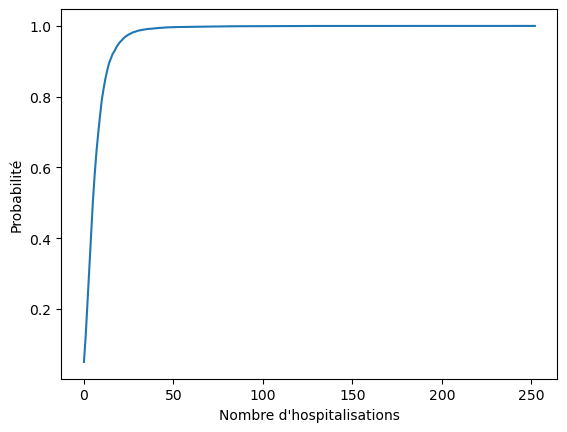

In [6]:
#CdF du nombre d'hospitalisations
(1-p_soins_df.describe().iloc[0]/len(p_soins_list)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
#plt.axhline(y = 0.95, color='r', linestyle='-.', label="0.95")
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
#plt.legend()

### Pour les patients avec une hospitalisation pour un GHM '05M09x', en considérant cette hospitalisation comme début de parcours 

In [7]:
p_soins_IC=[]
for patient in tqdm(range(len(p_soins))):
    parcours=p_soins.iloc[patient].dropna()
    if parcours.eq('05M091').any():
        start=0
        while parcours.tolist()[start] not in ['05M091', '05M092', '05M093', '05M09T']:
            start+=1
        p_soins_IC.append(parcours.tolist()[start:-1])

100%|██████████| 10051/10051 [00:07<00:00, 1271.24it/s]


In [8]:
p_soins_IC_df=pd.DataFrame(p_soins_IC)
p_soins_IC_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,05M091,05M171,05M13T,05M13T,05M13T,05K061,05M13T,05M13T,05M13T,05K241,...,None,None,None,None,None,None,None,None,None,None
1,05M091,23K02Z,09C081,09C082,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,05M091,05K111,05M15T,19M062,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,05M093,16M112,05M091,05M092,05M092,05M093,05M092,05M093,None,None,...,None,None,None,None,None,None,None,None,None,None
4,05M091,05M09T,05M093,05M093,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [9]:
p_soins_IC_df[1].describe()

count        829
unique       261
top       05M091
freq         106
Name: 1, dtype: object

Text(0, 0.5, 'Probabilité')

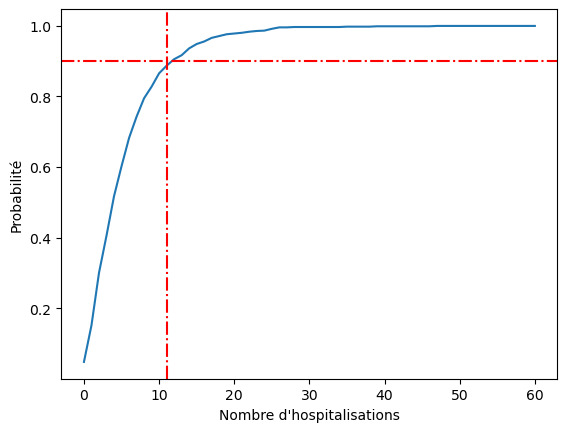

In [10]:
#CdF du nombre d'hospitalisations
(1-p_soins_IC_df.describe().iloc[0]/len(p_soins_IC)).plot()
#plt.axhline(y = 0.5, color='r', linestyle='-', label="0.5")
#plt.axhline(y = 0.05, color='r', linestyle='--', label="0.05")
plt.axvline(x = 11, color='r', linestyle='-.', label="0.95")
plt.axhline(y = 0.90, color='r', linestyle='-.', label="0.95")
plt.xlabel("Nombre d'hospitalisations")
plt.ylabel("Probabilité")
#plt.legend()

## Flux de patients

In [11]:
# On retire les entrées n'ayant aucune hospitalisation
p_soins_IC_df = p_soins_IC_df.dropna(thresh=1).reset_index(drop=True)

In [12]:
# On récupère le nombre de patients qui connaissent une nième hospitalisation, jusqu'à l'hospitalisation 11 (90% du dataset)
hospit_n=p_soins_IC_df.describe().iloc[0]
hospit_n=pd.DataFrame(hospit_n)
hospit_n

,count
0,930
1,829
2,684
3,581
4,472
...,...
56,1
57,1
58,1
59,1


In [13]:
p_soins_IC_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,930,829,684,581,472,389,311,252,201,169,...,1,1,1,1,1,1,1,1,1,1
unique,4,261,278,259,220,202,171,136,138,118,...,1,1,1,1,1,1,1,1,1,1
top,05M091,05M091,05M091,05M091,05M092,05M091,05M092,05M092,05M092,05M092,...,05K15J,05M191,05K15J,21M151,05K15J,05K101,05K15J,05K15J,05K15J,05K15J
freq,725,106,74,54,41,26,27,21,17,13,...,1,1,1,1,1,1,1,1,1,1


In [14]:
df=pd.DataFrame(p_soins_IC_df[0].value_counts())
for i in range(1,p_soins_IC_df.shape[1]):
    df=pd.concat([df, pd.DataFrame(p_soins_IC_df[i].value_counts())], axis=1)

In [15]:
df=df.transpose()
df.head()

,05M091,05M092,05M093,05M09T,05K101,02C05J,05M081,05M08T,04M053,05K102,...,06M192,01M222,17M163,05C212,01M35T,21M152,03M073,04C024,10M083,21M151
0,725.0,101.0,52.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106.0,58.0,26.0,20.0,54.0,17.0,15.0,12.0,12.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,74.0,60.0,27.0,15.0,12.0,17.0,8.0,5.0,8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.0,42.0,23.0,10.0,10.0,20.0,5.0,5.0,9.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.0,41.0,23.0,15.0,10.0,12.0,1.0,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Export des différents types d'hospitalisations et de leur nombre
df.to_csv("./data/hospit_IC.csv")

### On regroupe les GHM pour Insuffisances cardiaques ('05M091', '05M092', '05M093' et '05M09T')

In [17]:
df['05M09x']=df[['05M091', '05M092', '05M093', '05M09T']].sum(axis=1)
df=df.drop(['05M091', '05M092', '05M093', '05M09T'], axis=1)

In [18]:
cols = list(df.columns)
cols=['05M09x']+cols[:-1]
df=df[cols]

In [19]:
df.head()

,05M09x,05K101,02C05J,05M081,05M08T,04M053,05K102,05K062,23K02Z,05C151,...,06M192,01M222,17M163,05C212,01M35T,21M152,03M073,04C024,10M083,21M151
0,930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,210.0,54.0,17.0,15.0,12.0,12.0,11.0,10.0,9.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,176.0,12.0,17.0,8.0,5.0,8.0,5.0,3.0,5.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,129.0,10.0,20.0,5.0,5.0,9.0,6.0,NaN,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,108.0,10.0,12.0,1.0,2.0,5.0,NaN,3.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


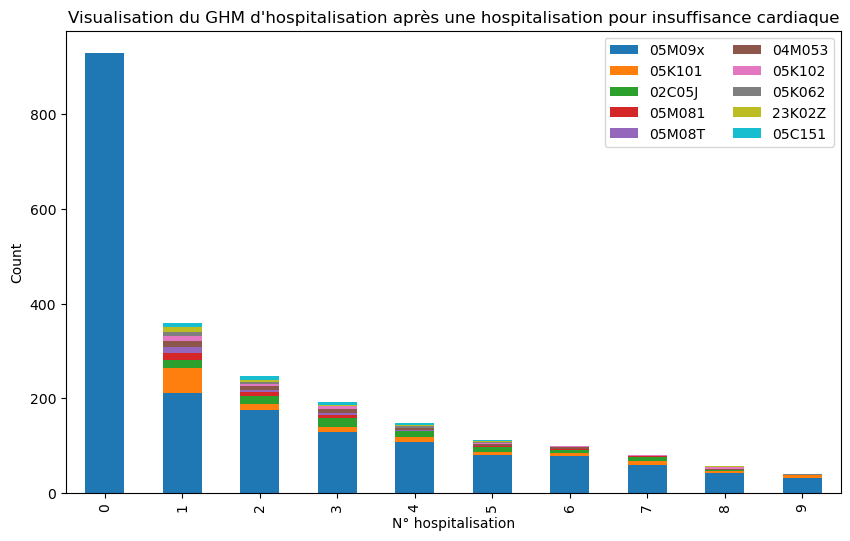

In [20]:
df.iloc[:10,:10].plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="upper right", ncol=2)
plt.xlabel("N° hospitalisation")
plt.ylabel("Count")
plt.title('Visualisation du GHM d\'hospitalisation après une hospitalisation pour insuffisance cardiaque')
plt.show()

## Calcul des proportions

In [34]:
prop=hospit_n[hospit_n.columns.repeat(df.shape[1])]
cols=df.columns
prop.columns=cols

In [35]:
prop.head()

,05M09x,05K101,02C05J,05M081,05M08T,04M053,05K102,05K062,23K02Z,05C151,...,06M192,01M222,17M163,05C212,01M35T,21M152,03M073,04C024,10M083,21M151
0,930,930,930,930,930,930,930,930,930,930,...,930,930,930,930,930,930,930,930,930,930
1,829,829,829,829,829,829,829,829,829,829,...,829,829,829,829,829,829,829,829,829,829
2,684,684,684,684,684,684,684,684,684,684,...,684,684,684,684,684,684,684,684,684,684
3,581,581,581,581,581,581,581,581,581,581,...,581,581,581,581,581,581,581,581,581,581
4,472,472,472,472,472,472,472,472,472,472,...,472,472,472,472,472,472,472,472,472,472


In [37]:
df=df/prop

In [43]:
df.head()

,05M09x,05K101,02C05J,05M081,05M08T,04M053,05K102,05K062,23K02Z,05C151,...,06M192,01M222,17M163,05C212,01M35T,21M152,03M073,04C024,10M083,21M151
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.253317,0.065139,0.020507,0.018094,0.014475,0.014475,0.013269,0.012063,0.010856,0.010856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.25731,0.017544,0.024854,0.011696,0.00731,0.011696,0.00731,0.004386,0.00731,0.010234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.222031,0.017212,0.034423,0.008606,0.008606,0.015491,0.010327,NaN,0.001721,0.013769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.228814,0.021186,0.025424,0.002119,0.004237,0.010593,NaN,0.006356,0.004237,0.008475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.iloc[:15,:15]

,05M09x,05K101,02C05J,05M081,05M08T,04M053,05K102,05K062,23K02Z,05C151,05K17J,05K061,23M20T,23M20Z,01M34Z
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.253317,0.065139,0.020507,0.018094,0.014475,0.014475,0.013269,0.012063,0.010856,0.010856,0.010856,0.010856,0.00965,0.00965,0.008444
2,0.25731,0.017544,0.024854,0.011696,0.00731,0.011696,0.00731,0.004386,0.00731,0.010234,0.004386,0.008772,0.010234,0.017544,0.00731
3,0.222031,0.017212,0.034423,0.008606,0.008606,0.015491,0.010327,NaN,0.001721,0.013769,0.003442,0.001721,0.006885,0.013769,0.001721
4,0.228814,0.021186,0.025424,0.002119,0.004237,0.010593,NaN,0.006356,0.004237,0.008475,0.006356,0.010593,0.019068,0.014831,0.004237
5,0.203085,0.017995,0.025707,0.005141,0.005141,0.010283,0.002571,0.007712,0.005141,0.005141,NaN,0.015424,0.010283,0.015424,0.005141
6,0.250804,0.022508,0.019293,0.003215,NaN,0.016077,0.003215,0.006431,NaN,NaN,NaN,0.003215,0.009646,0.012862,0.006431
7,0.234127,0.035714,0.027778,0.011905,NaN,NaN,0.003968,NaN,0.007937,NaN,0.003968,0.015873,0.007937,0.02381,NaN
8,0.208955,0.0199,0.00995,NaN,0.004975,0.00995,0.014925,0.004975,0.00995,NaN,NaN,0.004975,0.0199,0.029851,NaN
9,0.189349,0.029586,NaN,NaN,NaN,NaN,NaN,0.011834,NaN,0.005917,0.011834,0.005917,0.005917,0.005917,0.005917


In [56]:
df.iloc[1].sort_values(ascending=False)[:10]

05M09x    0.253317
05K101    0.065139
02C05J    0.020507
05M081    0.018094
05M08T    0.014475
04M053    0.014475
05K102    0.013269
05K062    0.012063
05K061    0.010856
05K17J    0.010856
Name: 1, dtype: object

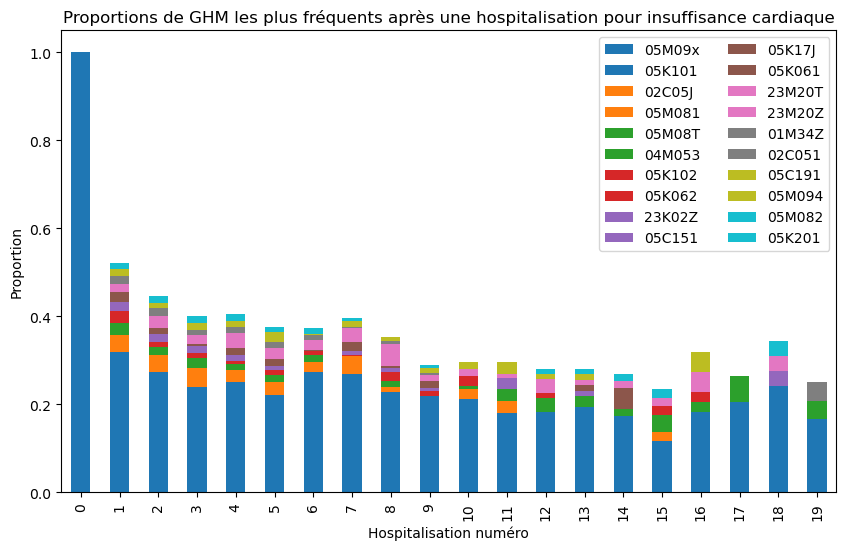

In [57]:
df.iloc[:20,:20].plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="upper right", ncol=2)
plt.xlabel("Hospitalisation numéro")
plt.ylabel("Proportion")
plt.title('Proportions de GHM les plus fréquents après une hospitalisation pour insuffisance cardiaque')
plt.show()